In [2]:
import pandas  as pd
import numpy as np
import re
import string
import os
import nltk
import collections, numpy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, LSTM,  Flatten, Input,MaxPooling1D,  GlobalMaxPooling1D,Flatten, Dense, Dropout ,Conv1D
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import roc_auc_score , multilabel_confusion_matrix, accuracy_score
from nltk.corpus import wordnet 
import random

In [3]:
df_data = pd.read_csv('data.csv')

In [4]:
df_data.head()


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
df_data.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [6]:
######vytvorenie mnoziny s 2 potrebnymi stlpcami
df_data=df_data[['target', 'comment_text']]
df_data.head(5)

,target,comment_text
0,0.000000,"This is so cool. It's like, 'would you want yo..."
1,0.000000,Thank you!! This would make my life a lot less...
2,0.000000,This is such an urgent design problem; kudos t...
3,0.000000,Is this something I'll be able to install on m...
4,0.893617,haha you guys are a bunch of losers.


In [7]:
###vsetky tagret, ktore maju hodnotu vysiou ako 0.5 tak maju hodnotu 1 toxic a nakopak
def assign_class(target):
    if target >= .5:
        return 1
    else: 
        return 0
df_data['target'] = df_data.apply(lambda x: assign_class(x['target']), axis= 1)
df_data.head(5)  
df_data.target.value_counts() ####kolko je 0 a kolko ma hodnotenie 1

0    1660540
1     144334
Name: target, dtype: int64

In [8]:
df_data.head(5)

,target,comment_text
0,0,"This is so cool. It's like, 'would you want yo..."
1,0,Thank you!! This would make my life a lot less...
2,0,This is such an urgent design problem; kudos t...
3,0,Is this something I'll be able to install on m...
4,1,haha you guys are a bunch of losers.


In [9]:
###kolko je chybajucich hodnot
df_data.isnull().sum()

target          0
comment_text    0
dtype: int64

In [10]:
df_data.comment_text.replace('', np.NaN, inplace=True) ###nahradenie prazdneho riadka hodnotou NAN
df_data.info()
np.sum(df_data.isnull().any(axis=1))
df_data[df_data.isnull().any(axis=1)].head()
df_data.dropna(inplace=True)  ###odstranneie riadkov NaN
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   target        int64 
 1   comment_text  object
dtypes: int64(1), object(1)
memory usage: 27.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 0 to 1804873
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   target        int64 
 1   comment_text  object
dtypes: int64(1), object(1)
memory usage: 41.3+ MB


Text(0.5, 1.0, 'Zobrazenie dlzky komentárov')

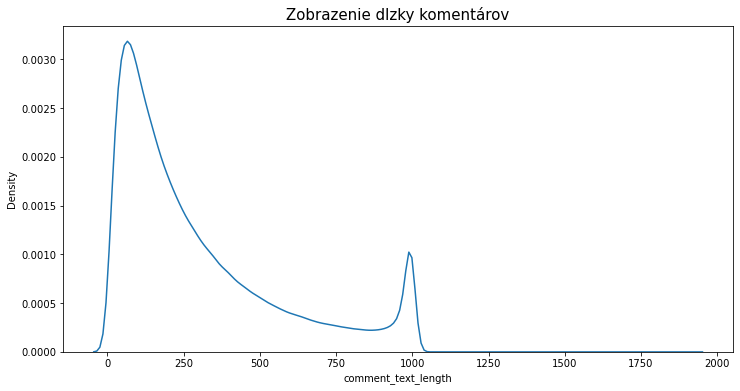

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
########vizualizacia dlzky komnetarov
df_data['comment_text_length'] = df_data['comment_text'].apply(lambda x : len(x))
fig, axarr = plt.subplots(1,1,figsize=(12, 6))
sns.kdeplot(df_data['comment_text_length']).set_title("Zobrazenie dlzky komentárov", fontsize=15)


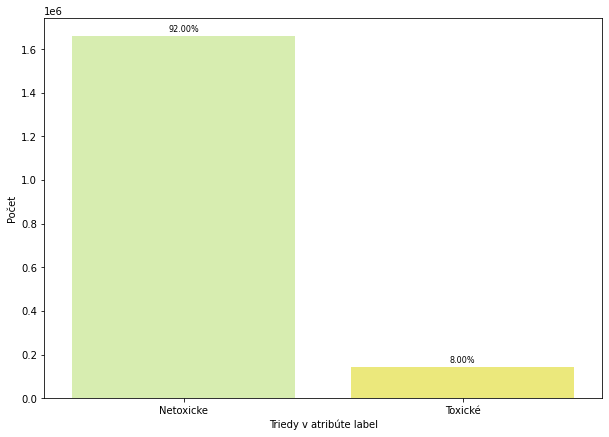

In [12]:
plt.figure(figsize=(10,7))
plot = sns.countplot(x='target', data=pd.DataFrame(df_data['target'].map({False:'Netoxicke',True:'Toxické'}), columns=['target']),palette=["#DAF7A6", "#FDFA6A"])

ax = plot.axes
ax.set(xlabel="Triedy v atribúte label", ylabel = "Počet")


for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / df_data.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')


In [13]:
df_data.comment_text[1]

"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"

In [14]:
###ulozenie dat
df_data.to_csv('data_preprocess.csv',index=False)

In [3]:
print('Loading data...')
data= pd.read_csv('data_preprocess.csv')

Loading data...


In [4]:
x = data["comment_text"].fillna("fillna")
y = data["target"].values
SEED = 42
x_train,x_test, y_train ,y_test= train_test_split(x, y, test_size=0.2, random_state=SEED)

print ("Celkový počet trénovacich príkladov je {0} z toho  {1:.2f}% je netoxických a {2:.2f}% je toxických".format(len(x_train),
                      (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))

print ("Celkový počet testovacich príkladov je {0} z toho {1:.2f}% je netoxických a {2:.2f}% je toxických".format(len(x_test),
                      (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))
  

Celkový počet trénovacich príkladov je 1443899 z toho  92.02% je netoxických a 7.98% je toxických
Celkový počet testovacich príkladov je 360975 z toho 91.94% je netoxických a 8.06% je toxických


In [19]:
x_train.to_csv('train.csv',index=False)  
np.save('train_label',y_train)  
x_test.to_csv('test.csv',index=False)  
np.save('test_label',y_test) 



In [14]:
x_train=pd.read_csv('train.csv',squeeze = True)
y_train=np.load('train_label.npy') 
x_test=pd.read_csv('test.csv',squeeze = True)
y_test=np.load('test_label.npy') 

In [5]:
EMBEDDING_DIM = 300 
max_features = 50000 
max_length = 200

In [6]:
EMBEDDING_FILE = 'glove.840B.300d.txt' # nacitanie slovnika glove
embeddings_index = {}
f = open(os.path.join('','glove.840B.300d.txt'), encoding = "utf-8")
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [23]:
print("Tokenizacia")
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

Tokenizacia


In [24]:
x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

In [25]:
word_index = tokenizer.word_index
print("Emmbedings matica...")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Emmbedings matica...
353110


(353110, 300)

In [ ]:
####MODELOVANIE 
####Zakladny model CNN
model= Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model.add(e)
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

saved_model = "model.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=2, callbacks=[checkpoint], validation_split=0.1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          105933000 
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0

In [29]:
print("Načítanie modelu....")
model = load_model('model.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
# roc auc score
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

# CR/CM
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))


Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9461014787290275
Úspešnosť je 0.948511669783226
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    331897
           1       0.78      0.50      0.61     29078

    accuracy                           0.95    360975
   macro avg       0.87      0.74      0.79    360975
weighted avg       0.94      0.95      0.94    360975

Kontigenčná tabuľka
[[327845   4052]
 [ 14534  14544]]


In [18]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
print("Modely rozsirenia EDA")

print("Nahradenie synonym")
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)
def synonym_replacement(words, n=4):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return sentence

toxic = x_train[y_train==1]
x_synonym = toxic.apply(synonym_replacement)
y_synonym= np.ones(len(x_synonym))


Modely rozsirenia EDA
Nahradenie synonym


In [20]:
x_syn=pd.concat([x_train,x_synonym])
y_syn=np.concatenate((y_train,y_synonym), axis=0)
y_syn= y_syn.astype('int64')

In [21]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_syn))



Counter({0: 1328643, 1: 115256})
Counter({0: 1328643, 1: 230512})


In [22]:
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_syn)
sequences_train = tokenizer.texts_to_sequences(x_syn)
sequences_test = tokenizer.texts_to_sequences(x_test)

###sekvenice kazde cislo zobrazuje jedno slovo vo vete

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
356279


(356279, 300)

In [ ]:

model_syn = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_syn.add(e)
model_syn.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_syn.add(MaxPooling1D(2))
model_syn.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_syn.add(MaxPooling1D(2))
model_syn.add(Flatten())
model_syn.add(Dropout(0.2))
model_syn.add(Dense(128, activation='relu'))
model_syn.add(Dense(1, activation='sigmoid'))
model_syn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_syn.summary()

saved_model_syn= "model_syn.hdf5"
checkpoint = ModelCheckpoint(saved_model_syn, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_syn.fit(x_train_seq, y_syn,epochs=2, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          106883700 
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0

In [25]:
print("Načítanie modelu....")
model = load_model('model_syn.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
# roc auc score
print('Roc auc skore je {}'.format(roc_auc_score(y_test,y_pred)))

# CR/CM
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))

Načítanie modelu....
Vyhodnotenie...
Roc auc skore je 0.9509352081045902
Úspešnosť je 0.9480822771660087
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    331897
           1       0.74      0.55      0.63     29078

    accuracy                           0.95    360975
   macro avg       0.85      0.76      0.80    360975
weighted avg       0.94      0.95      0.94    360975

Kontigenčná tabuľka
[[326345   5552]
 [ 13189  15889]]


In [26]:
####NAHODNE VLOZENIE
print("Náhodne vloženie")
def random_insertion(words, n=3):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)
    
toxic = x_train[y_train==1]


x_insert = toxic.apply(random_insertion)
y_insert= np.ones(len(x_insert))

x_random_insert=pd.concat([x_train,x_insert])
y_random_insert=np.concatenate((y_train,y_insert), axis=0)
y_random_insert= y_random_insert.astype('int64')



Náhodne vloženie


In [30]:
print(toxic.head(10))

1300354    Fox news is more polished than local conservat...
368791     wow\n\ncan we apply that litmus test to muslim...
745600     So everything is exactly as it appeared...Trum...
1290210    Elect a clown, expect a circus! It's a shame t...
412024     Where the rest of Canada, lead by our idiot PM...
230989     Murkowski has always been a RINO.  Sullivan is...
1637565    Republicans really have ZERO abilities to pull...
31146      My daughter heard the shots! You, sir, are a v...
834694     You didn't read the studies did you? Of course...
119295     Absolutely Stupid and Degrading of this "Counc...
Name: comment_text, dtype: object


In [31]:
print(x_insert[31146])

My daughter heard upright the shots! equal You, sir, are a very lucky man that idiot didn't shoot you too. Amazing. Ignore the haters. From what I've heard, your dog was just barking, not attacking. Nail him to the cad wall.


In [32]:
print(x_train[31146])

My daughter heard the shots! You, sir, are a very lucky man that idiot didn't shoot you too. Amazing. Ignore the haters. From what I've heard, your dog was just barking, not attacking. Nail him to the wall.


In [27]:
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_random_insert)
sequences_train = tokenizer.texts_to_sequences(x_random_insert)
sequences_test = tokenizer.texts_to_sequences(x_test)

###sekvenice kazde cislo zobrazuje jedno slovo vo vete

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matica....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape

Tokenizacia
Emmbedings matica....
354162


(354162, 300)

In [ ]:
model_interest= Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_interest.add(e)
model_interest.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_interest.add(MaxPooling1D(2))
model_interest.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_interest.add(MaxPooling1D(2))
model_interest.add(Flatten())
model_interest.add(Dropout(0.2))
model_interest.add(Dense(128, activation='relu'))
model_interest.add(Dense(1, activation='sigmoid'))
model_interest.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_interest.summary()

saved_model_interest = "model_insert.hdf5"
checkpoint = ModelCheckpoint(saved_model_interest, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_interest.fit(x_train_seq, y_random_insert,epochs=2, batch_size=32,callbacks=[checkpoint],validation_split=0.1)
model_interest.save('model_insert.hdf5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          106248600 
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 64)           19264     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 64)           4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3200)             

In [33]:
print("Načítanie modelu....")
model = load_model('model_insert.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))


y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))


print(collections.Counter(y_train))
print(collections.Counter(y_random_insert))

Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9507565846780237
Úspešnosť je 0.9484313318096821
              precision    recall  f1-score   support

           0       0.96      0.98      0.97    331897
           1       0.74      0.55      0.63     29078

    accuracy                           0.95    360975
   macro avg       0.85      0.77      0.80    360975
weighted avg       0.94      0.95      0.94    360975

Kontigenčná tabuľka
[[326385   5512]
 [ 13103  15975]]
Counter({0: 1328643, 1: 115256})
Counter({0: 1328643, 1: 230512})


In [7]:
####nahodna vymena
print("Náhodná výmena")
def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n=3):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

toxic = x_train[y_train==1]


x_swap = toxic.apply(random_swap)
y_swap= np.ones(len(x_swap))

x_random_swap=pd.concat([x_train,x_swap])
y_random_swap=np.concatenate((y_train,y_swap), axis=0)
y_random_swap= y_random_swap.astype('int64')






Náhodná výmena


In [8]:
print(x_swap[31146])

My daughter heard the shots! the sir, are that too. lucky man a idiot didn't shoot you very Amazing. Ignore You, haters. From what I've heard, your dog was just barking, not attacking. Nail him to the wall.


In [9]:
print(x_train[31146])

My daughter heard the shots! You, sir, are a very lucky man that idiot didn't shoot you too. Amazing. Ignore the haters. From what I've heard, your dog was just barking, not attacking. Nail him to the wall.


In [10]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_random_swap)
sequences_test = tokenizer.texts_to_sequences(x_test)

###sekvenice kazde cislo zobrazuje jedno slovo vo vete

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
353110


(353110, 300)

In [ ]:
####MODELOVANIE
###Model1
model_swap = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_swap.add(e)
model_swap.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_swap.add(MaxPooling1D(2))
model_swap.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_swap.add(MaxPooling1D(2))
model_swap.add(Flatten())
model_swap.add(Dropout(0.2))
model_swap.add(Dense(128, activation='relu'))
model_swap.add(Dense(1, activation='sigmoid'))
model_swap.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_swap.summary()

saved_model_swap = "model_swap.hdf5"
checkpoint = ModelCheckpoint(saved_model_swap, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_swap.fit(x_train_seq, y_random_swap,epochs=2, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 300)          105933000 
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0

In [14]:
print("Načítanie modelu....")
model = load_model('model_swap.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
# roc auc score
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

# CR/CM
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))


print(collections.Counter(y_train))
print(collections.Counter(y_random_swap))


Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9505171375519843
Úspešnosť je 0.9482761964124939
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    331897
           1       0.76      0.52      0.62     29078

    accuracy                           0.95    360975
   macro avg       0.86      0.75      0.80    360975
weighted avg       0.94      0.95      0.94    360975

Kontigenčná tabuľka
[[327216   4681]
 [ 13990  15088]]
Counter({0: 1328643, 1: 115256})
Counter({0: 1328643, 1: 230512})


In [8]:
print("Náhodné vymazanie")
def random_deletion(words, p=0.11):

    words = words.split()
    
   # zjavne, ak je iba jedno slovo,  ho
    if len(words) == 1:
        return words

    #skutocne mazat slovs pravdepodobnostou str
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    # ak nakoniec 
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence


toxic = x_train[y_train==1]
x_del = toxic.apply(random_deletion)
y_del= np.ones(len(x_del))

x_random_del=pd.concat([x_train,x_del])
y_random_del=np.concatenate((y_train,y_del), axis=0)
y_random_del= y_random_del.astype('int64')



Náhodné vymazanie


In [9]:
print(x_del[31146])

daughter heard the shots! sir, are a very lucky man that idiot didn't shoot you too. Amazing. Ignore the haters. From what I've heard, your dog just barking, not attacking. Nail him to the wall.


In [10]:
print(x_train[31146])

My daughter heard the shots! You, sir, are a very lucky man that idiot didn't shoot you too. Amazing. Ignore the haters. From what I've heard, your dog was just barking, not attacking. Nail him to the wall.


In [11]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_random_del)
sequences_train = tokenizer.texts_to_sequences(x_random_del)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matica....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matica....
353320


(353320, 300)

In [ ]:
model_del = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_del.add(e)
model_del.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_del.add(MaxPooling1D(2))
model_del.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_del.add(MaxPooling1D(2))
model_del.add(Flatten())
model_del.add(Dropout(0.2))
model_del.add(Dense(128, activation='relu'))
model_del.add(Dense(1, activation='sigmoid'))
model_del.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_del.summary()

saved_model_del = "model_del.hdf5"
checkpoint = ModelCheckpoint(saved_model_del, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_del.fit(x_train_seq, y_random_del,epochs=2, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          105996000 
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 64)           19264     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 100, 64)           4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3200)             

In [15]:
print("Načítanie modelu....")
model = load_model('model_del.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
# roc auc score
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

# CR/CM
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je{}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))


print(collections.Counter(y_train))
print(collections.Counter(y_random_swap))


Načítanie modlu....


KeyError: "Unable to open object (object 'max_pooling1d_2' doesn't exist)"

In [23]:
#####Spojeniee metod eda
x_eda=np.concatenate((x_syn,x_swap,x_insert,x_del,x_train), axis=0)
y_eda=np.concatenate((y_syn,y_swap,y_insert,y_del,y_train), axis=0)
y_eda= y_eda.astype('int64')



<ipython-input-23-02d904dbc5fe>:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  y_eda= y_eda.astype('Int64')


Tokenizacia
Najdenych 353109 jedinecnych tokenov.
Emmbedings matrix....
353110


(353110, 300)

In [ ]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_eda)
sequences_test = tokenizer.texts_to_sequences(x_test)



x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

In [ ]:
####MODELOVANIE
model_eda = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_eda.add(e)
model_eda.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_eda.add(MaxPooling1D(2))
model_eda.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_eda.add(MaxPooling1D(2))
model_eda.add(Flatten())
model_eda.add(Dropout(0.2))
model_eda.add(Dense(128, activation='relu'))
model_eda.add(Dense(1, activation='sigmoid'))
model_eda.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_eda.summary()

saved_eda = "model_eda4_metody.hdf5"
checkpoint = ModelCheckpoint(saved_eda, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# TrÃ©novanie modelu
print('Trénovanie modelu..')
history = model_eda.fit(x_train_seq, y_eda,epochs=1, batch_size=32,callbacks=[checkpoint],validation_split=0.1)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 300)          105933000 
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 200, 64)           19264     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 100, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 100, 64)           4160      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3200)             

In [ ]:
print("Načítanie modelu....")
model = load_model('model_eda4_metody.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
# roc auc score
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

# CR/CM
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))

collections.Counter(y_train)
collections.Counter(y_eda)

Loading model....
Vyhodnotenie...
